In [1]:
import time
import numpy as np

import matplotlib.pyplot as plt
import qutip as qt
from scipy import integrate

import UD_liouv as RC
import driving_liouv as EM

import phonon_weak_coupling as WC

from qutip import ket, basis, sigmam, sigmap, sigmaz, spre, sprepost, spost, destroy, mesolve, tensor, qeye, Qobj
from numpy import pi, linspace, sqrt
from utils import J_overdamped, beta_f, J_underdamped, J_minimal_hard, J_multipolar
from utils import ground_and_excited_states, initialise_TLS
from utils import save_obj, load_obj

from fermionic_leads import current_vs_phonon_coupling, current_from_L, L_R_lead_dissipators, build_H
import fermionic_leads as fl

The main photocell figures of merit are $C_{sc}$, $V_{oc}$ and $P_{max}$ which can all be found from a current-voltage diagram. Firstly, need an environment where all of the phonon, lead and optical parameters are defined to check the sort of phonon occupations that occur with some fair parameters. I'll refactor the old optical-free `current_vs_phonon_coupling` code to do this.

In [2]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

kB = 0.695
EE = basis(2,1)*basis(2,1).dag()
GG = basis(2,0)*basis(2,0).dag()
Zero = tensor(basis(2,0), basis(2,0))
sz = EE - GG
sm = destroy(2)
d2 = tensor(sm, sz) # swapped around from the calculations
d1 = tensor(qeye(2), sm)
I_sys = Qobj(qeye(4), dims= [[2, 2], [2, 2]])
d1dag, d2dag = d1.dag(), d2.dag()

z_ket = basis(4,0)
l_ket = basis(4,1)
lp_ket = basis(4,2)
d_ket = basis(4,3)

D = d1dag*d1*d2dag*d2
Z = Qobj(z_ket*z_ket.dag(), dims=D.dims)
LUMO = Qobj(l_ket*l_ket.dag(), dims=D.dims)
LUMOp = Qobj(lp_ket*lp_ket.dag(), dims=D.dims)
n_sub = d1dag*d1 + d2dag*d2 # populatiion operator

J_leads = J_underdamped
J_EM = J_multipolar

def build_H(eps1, eps2, U):
    return eps1*d1dag*d1 + eps2*d2dag*d2 + U*D

In [9]:
reload(fl)
def current_method_tester(eps1, eps2, T_EM=1000., Gamma_EM=0.5, T_ph=77., 
                            alphaph=100., Gamma=30., w0=70., U=0., N=10,
                               gamma_L=1., T_L=77., width_L=1000., pos_L=1000.,
                               gamma_R=1., T_R=77., width_R=1000., pos_R=1000.,
                               height_L=1., height_R=1., V = 3000.):
    
    mu0 = (eps1+eps2)/2.
    
    eps = abs(eps2-eps1)
    V_values = np. linspace(0., eps, 35)
    print "RC would need {} states to fill electronic gap.".format(eps/w0)
    print "Gap is {} times kBT.".format( eps/(0.695*T_EM))
    currents_nonadd = []
    currents_add = []
    H = build_H(eps1, eps2, U)
    d_sub = d1+d2
    d_RC = tensor(d_sub, qeye(N))
    E_RC = tensor(n_sub, qeye(N))
    RC_occ = destroy(N).dag()*destroy(N)
    RC_occ_ = tensor(I_sys, RC_occ)
    obs_ops = [E_RC, RC_occ_]
    alpha_ph = alphaph/pi

    L_RC, H_RC, A_EM, A_nrwa, Z, _, _, _ = fl.RC_function_UD(H, n_sub, d_sub, T_ph,
                                                        Gamma, w0, alpha_ph,
                                                        N, silent=True)
    L_Lfull, L_Rfull = fl.L_R_lead_dissipators(H_RC, d_RC,
                                        T_L=T_L, mu_L=mu0-(V/2.), width_L=width_L,
                                        pos_L=pos_L, height_L=height_L,
                                        T_R=T_R, mu_R=mu0+(V/2.), width_R=width_R,
                                        pos_R=pos_R, height_R=height_R, silent=False)
    L_EM_full = EM.L_non_rwa(H_RC, A_nrwa, eps, Gamma_EM, T_EM, J=J_EM, silent=True)
    L_full = L_RC+L_Lfull+L_Rfull+L_EM_full
    n_reps = 10
    for meth in ['direct', 'iterative-gmres', 
                 'iterative-lgmres', 'iterative-bicgstab']:
        ti = time.time()
        for _ in range(n_reps):
            fl.current_from_L(H_RC, L_full, L_Rfull, obs_ops, method=meth)
        print "each loop using {} took {} seconds".format(meth, (time.time()-ti)/n_reps)

eps2, eps1 = 2000,200
N =12
print "V = 3000."
current_method_tester(eps2, eps1, T_EM=1000., Gamma_EM=0.5, T_ph=77., 
                           alphaph=200., Gamma=30., w0=70., U=0., N=N,
                           gamma_L=1., T_L=77., width_L=eps2, pos_L=eps2,
                           gamma_R=1., T_R=77., width_R=eps2, pos_R=eps2,
                           height_L=1., height_R=1., V = 4000.)
print "V = 100."
current_method_tester(eps2, eps1, T_EM=1000., Gamma_EM=0.5, T_ph=77., 
                           alphaph=200., Gamma=30., w0=70., U=0., N=N,
                           gamma_L=1., T_L=77., width_L=eps2, pos_L=eps2,
                           gamma_R=1., T_R=77., width_R=eps2, pos_R=eps2,
                           height_L=1., height_R=1., V = 0.)
print "V = 1000."
current_method_tester(eps2, eps1, T_EM=1000., Gamma_EM=0.5, T_ph=77., 
                           alphaph=200., Gamma=30., w0=70., U=0., N=N,
                           gamma_L=1., T_L=77., width_L=eps2, pos_L=eps2,
                           gamma_R=1., T_R=77., width_R=eps2, pos_R=eps2,
                           height_L=1., height_R=1., V = 100.)

V = 3000.
RC would need 25.7142857143 states to fill electronic gap.
Gap is 2.58992805755 times kBT.
Calculating the lead dissipators took 22.0841300488 seconds.
each loop using direct took 0.575147795677 seconds
each loop using iterative-gmres took 1.51081340313 seconds
each loop using iterative-lgmres took 1.44923660755 seconds
each loop using iterative-bicgstab took 1.43921239376 seconds
V = 100.
RC would need 25.7142857143 states to fill electronic gap.
Gap is 2.58992805755 times kBT.
Calculating the lead dissipators took 28.3479239941 seconds.
each loop using direct took 0.612307810783 seconds
each loop using iterative-gmres took 1.45395169258 seconds
each loop using iterative-lgmres took 1.3240623951 seconds
each loop using iterative-bicgstab took 1.50296070576 seconds
V = 1000.
RC would need 25.7142857143 states to fill electronic gap.
Gap is 2.58992805755 times kBT.
Calculating the lead dissipators took 27.450521946 seconds.
each loop using direct took 0.534758996964 seconds
ea

In [8]:
print "V = 3000."
N = 12
current_method_tester(eps2, eps1, T_EM=1000., Gamma_EM=0.5, T_ph=77., 
                           alphaph=200., Gamma=30., w0=70., U=0., N=N,
                           gamma_L=1., T_L=77., width_L=eps2, pos_L=eps2,
                           gamma_R=1., T_R=77., width_R=eps2, pos_R=eps2,
                           height_L=1., height_R=1., V = 4000.)
print "V = 100."
current_method_tester(eps2, eps1, T_EM=1000., Gamma_EM=0.5, T_ph=77., 
                           alphaph=200., Gamma=30., w0=70., U=0., N=N,
                           gamma_L=1., T_L=77., width_L=eps2, pos_L=eps2,
                           gamma_R=1., T_R=77., width_R=eps2, pos_R=eps2,
                           height_L=1., height_R=1., V = 0.)
print "V = 1000."
current_method_tester(eps2, eps1, T_EM=1000., Gamma_EM=0.5, T_ph=77., 
                           alphaph=200., Gamma=30., w0=70., U=0., N=N,
                           gamma_L=1., T_L=77., width_L=eps2, pos_L=eps2,
                           gamma_R=1., T_R=77., width_R=eps2, pos_R=eps2,
                           height_L=1., height_R=1., V = 1000.)

V = 3000.


NameError: name 'current_method_tester' is not defined

In [4]:
reload(fl)
def photocurrent_vs_voltage(eps1, eps2, T_EM=1000., Gamma_EM=0.5, T_ph=77., 
                            alphaph=100., Gamma=30., w0=70., U=0., N=10,
                               gamma_L=1., T_L=77., width_L=1000., pos_L=1000.,
                               gamma_R=1., T_R=77., width_R=1000., pos_R=1000.,
                               height_L=1., height_R=1., method='direct'):
    ti = time.time()
    mu0 = (eps1+eps2)/2.
    
    eps = abs(eps2-eps1)
    V_values = np. linspace(0., eps, 35)
    print "RC would need {} states to fill electronic gap.".format(eps/w0)
    print "Gap is {} times kBT.".format( eps/(0.695*T_EM))
    currents_nonadd = []
    currents_add = []
    H = build_H(eps1, eps2, U)
    d_sub = d1+d2
    d_RC = tensor(d_sub, qeye(N))
    E_RC = tensor(n_sub, qeye(N))
    RC_occ = destroy(N).dag()*destroy(N)
    RC_occ_ = tensor(I_sys, RC_occ)
    obs_ops = [E_RC, RC_occ_]
    alpha_ph = alphaph/pi
    L_RC, H_RC, A_EM, A_nrwa, Z, _, _, _ = fl.RC_function_UD(H, n_sub, d_sub, T_ph,
                                                        Gamma, w0, alpha_ph,
                                                        N, silent=False)
    _, H_add, _, _, _, _, _, _ = fl.RC_function_UD(H, n_sub, d_sub, T_ph,
                                                        Gamma, w0, 0.,
                                                        N, silent=True)
    L_EM_add = EM.L_non_rwa(H_add, A_nrwa, eps, Gamma_EM, T_EM, J=J_EM, silent=True)
    L_EM_full = EM.L_non_rwa(H_RC, A_nrwa, eps, Gamma_EM, T_EM, J=J_EM, silent=True)
    for i, V in enumerate(V_values):
        L_Lfull, L_Rfull = fl.L_R_lead_dissipators(H_RC, d_RC,
                                            T_L=T_L, mu_L=mu0-(V/2.), width_L=width_L,
                                            pos_L=pos_L, height_L=height_L,
                                            T_R=T_R, mu_R=mu0+(V/2.), width_R=width_R,
                                            pos_R=pos_R, height_R=height_R)
        currents_add.append(fl.current_from_L(H_RC, L_RC+L_Lfull+L_Rfull+L_EM_add, 
                                            L_Rfull, obs_ops, method=method))
        currents_nonadd.append(fl.current_from_L(H_RC, L_RC+L_Lfull+L_Rfull+L_EM_full,
                                            L_Rfull, obs_ops, method=method))
        del L_Lfull, L_Rfull
        if (currents_add[-1][0].real <0) and (currents_nonadd[-1][0].real<0):
            # only interested up to zero current
            break
        if (i%10)==0:
            print 100*(float(i)/len(V_values)), "% complete"
    print "Took {} seconds.".format(time.time()-ti)
    # current_from_L spits out observables side-by-side so need to transpose
    currents_add = np.array(currents_add).T
    currents_nonadd = np.array(currents_nonadd).T
    return V_values[0: len(currents_add[0])], currents_add, currents_nonadd
print "silicon Gap is {} times bigger than kbT".format((1.5*8000)/(0.695*6000.))
eps1 = 2000.
eps2 = 200.
eps = (eps1-eps2)



v, ca, cna = photocurrent_vs_voltage(eps1, eps2, U=0., N=12,
                                     Gamma_EM=0.5, T_EM=1000., 
                                     T_ph=77., Gamma=30., w0=eps/15., alphaph=100., 
                                     gamma_L=1., T_L=77., width_L=eps, pos_L=eps1,
                                     gamma_R=1., T_R=77., width_R=eps, pos_R=eps1)
v0, ca0, cna0 = photocurrent_vs_voltage(eps1, eps2, U=0., N=3,
                                     Gamma_EM=0.5, T_EM=2000., 
                                     T_ph=77., Gamma=30., w0=eps/15., alphaph=1., 
                                     gamma_L=1., T_L=77., width_L=eps, pos_L=eps1,
                                     gamma_R=1., T_R=77., width_R=eps, pos_R=eps1)

silicon Gap is 2.87769784173 times bigger than kbT
RC would need 15.0 states to fill electronic gap.
Gap is 2.58992805755 times kBT.
w_RC=120.0 | RC-res. coupling=0.04 | TLS-RC coupling=77.46 | Gamma_RC=30.00 | alpha_ph=31.83 | N=12 |
0.0 % complete
28.5714285714 % complete
Took 701.139816046 seconds.
RC would need 15.0 states to fill electronic gap.
Gap is 1.29496402878 times kBT.
w_RC=120.0 | RC-res. coupling=0.04 | TLS-RC coupling=7.75 | Gamma_RC=30.00 | alpha_ph=0.32 | N=3 |
0.0 % complete
28.5714285714 % complete
57.1428571429 % complete
Took 43.0087518692 seconds.


In [ ]:
_v  = np.array([0,1,2,3,4,5,6])
_c1 = np.array([5,4,3,2,1,0,-1])
_c2 = np.array([4,3,2,1,0,-1,-2])
def short_current(v,c):
    return c[0]
def estimate_Voc(v, c):
    first_neg_c_id = len(c)-len([i for i in c if i<0])
    assert c[first_neg_c_id] <0 , "{} is not less than 0.". format(c[first_neg_c_id])
    assert c[first_neg_c_id-1] >=0, "{} is not greater than or equal to 0.".format(cc[first_neg_c_id-1])
    intercept = c[-2]
    m = (c[-2]-c[-1])/float(v[-2]-v[-1])
    pred_v = (-c[-2]/m)+v[-2]
    return pred_v

def power(v, c):
    return np.array(v)*np.array(c)

def max_power(p):
    # can make this more sophisticated at a later date
    return np.max(p)

def fill_factor(v, c):
    return max_power(power(v, c))/(c[0]*estimate_Voc(v, c))

assert estimate_Voc(_v, _c1) == 5.
assert estimate_Voc(_v, _c2)== 4.

In [6]:
v = np. linspace(0., eps, 35)[0:21]
v0 = np. linspace(0., eps, 35)[0:28]
print fill_factor(v0, ca0[0])
print fill_factor(v0, cna0[0])
print fill_factor(v, ca[0])
print fill_factor(v, cna[0])

(0.741448567825+0j)
(0.741440778425+0j)
(0.685845597199+0j)
(0.685239196638+0j)


Since the open-circuit has a greater percentage difference between additive and non-additive than the maximum power, the overall fill factor is actually lower in the non-additive case. It also drops for increasing phonon-coupling.

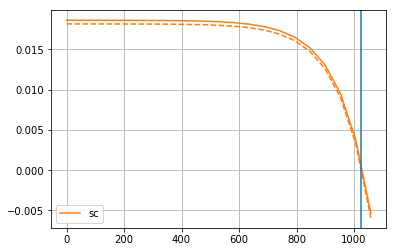

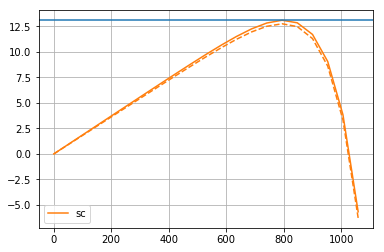

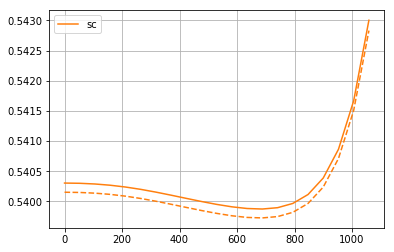

In [11]:

"""plt.plot(v0, ca0[0], ls='dashed', c=colors[0])
plt.plot(v0, cna0[0], label='wc', c=colors[0])"""
plt.plot(v, ca[0], ls='dashed', c=colors[1])
plt.plot(v, cna[0], label='sc', c=colors[1])
plt.axvline(estimate_Voc(v, ca[0]))
plt.grid()
plt.legend()

plt.figure()
plt.plot(v, power(v, ca[0]), ls='dashed', c=colors[1])
plt.plot(v, power(v, cna[0]), label='sc', c=colors[1])
plt.axhline(max_power(power(v, cna[0])))
plt.grid()
plt.legend()

plt.figure()
"""plt.plot(v0, ca0[1], ls='dashed', c=colors[0])
plt.plot(v0, cna0[1], label='wc', c=colors[0])"""
plt.plot(v, ca[1], ls='dashed', c=colors[1])
plt.plot(v, cna[1], label='sc', c=colors[1])
plt.legend()
plt.grid()
plt.show()

In [ ]:
reload(fl)
def current_vs_voltage_vs_phonon_coupling(eps1, eps2, T_EM=1000., Gamma_EM=0.5, T_ph=77., 
                                 alphaph=100., Gamma=30., w0=70., U=0., N=10,
                                 gamma_L=1., T_L=77., width_L=1000., pos_L=1000.,
                                 gamma_R=1., T_R=77., width_R=1000., pos_R=1000.,
                                 height_L=1., height_R=1., method='direct'):
    nonadd_data = []
    add_data = []
    ti = time.time()
    mu0 = (eps1+eps2)/2.
    eps = abs(eps2-eps1)
    
    print "RC would need {} states to fill electronic gap.".format(eps/w0)
    print "Gap is {} times kBT.".format( eps/(0.695*T_EM))
    
    H = build_H(eps1, eps2, U)
    d_sub = d1+d2
    
    alpha_values = np.linspace(0,0.2*eps,20)
    V_values = np. linspace(0., eps, 30)
    ti = time.time()
    for j, alpha in enumerate(alpha_values):
        alpha_ph = alpha/pi
        currents_nonadd = []
        currents_add = []
        if pi*alpha_ph < 0.05*eps:
            N = 10
        if pi*alpha_ph < 0.01*eps:
            N = 4
        
        d_RC = tensor(d_sub, qeye(N))
        E_RC = tensor(n_sub, qeye(N))
        RC_occ = destroy(N).dag()*destroy(N)
        RC_occ_ = tensor(I_sys, RC_occ)
        obs_ops = [E_RC, RC_occ_]
        L_RC, H_RC, A_EM, A_nrwa, Z, _, _, _ = fl.RC_function_UD(H, n_sub, d_sub, T_ph,
                                                                Gamma, w0, alpha_ph,
                                                                N, silent=True)
        _, H_add, _, _, _, _, _, _ = fl.RC_function_UD(H, n_sub, d_sub, T_ph,
                                                            Gamma, w0, 0.,
                                                            N, silent=True)
        del _, Z
        L_EM_add = EM.L_non_rwa(H_add, A_nrwa, eps, Gamma_EM, T_EM, J=J_EM, silent=True)
        L_EM_full = EM.L_non_rwa(H_RC, A_nrwa, eps, Gamma_EM, T_EM, J=J_EM, silent=True)
        for i, V in enumerate(V_values):
            
            L_Lfull, L_Rfull = fl.L_R_lead_dissipators(H_RC, d_RC,
                                                T_L=T_L, mu_L=mu0-(V/2), width_L=width_L,
                                                pos_L=pos_L, height_L=height_L,
                                                T_R=T_R, mu_R=mu0+(V/2), width_R=width_R,
                                                pos_R=pos_R, height_R=height_R)
            currents_add.append(fl.current_from_L(H_RC, L_RC+L_Lfull+L_Rfull+L_EM_add, 
                                                L_Rfull, obs_ops, method=method))
            currents_nonadd.append(fl.current_from_L(H_RC, L_RC+L_Lfull+L_Rfull+L_EM_full,
                                                L_Rfull, obs_ops, method=method))
            del L_Lfull, L_Rfull
            time.sleep(2)
            if (currents_add[-1][0].real <0) and (currents_nonadd[-1][0].real<0):
                # only interested up to zero current
                break
        print 100*(float(j+1)/len(alpha_values)), "% complete"
        add_data.append(np.array(currents_add).T)
        nonadd_data.append(np.array(currents_nonadd).T)
    print "Took {} seconds.".format(time.time() - ti)
    return alpha_values, V_values, add_data, nonadd_data

eps1 = 2000.
eps2 = 200.
eps = (eps1-eps2)

alpha_values, V_values, add_data, nonadd_data = current_vs_voltage_vs_phonon_coupling(
                                     eps1, eps2, U=0., N=12, Gamma_EM=0.5, T_EM=1000., 
                                     T_ph=77., Gamma=30., w0=eps/15., alphaph=100., 
                                     gamma_L=1., T_L=77., width_L=eps, pos_L=eps1,
                                     gamma_R=1., T_R=77., width_R=eps, pos_R=eps1)

RC would need 15.0 states to fill electronic gap.
Gap is 2.58992805755 times kBT.
5.0 % complete
10.0 % complete
15.0 % complete


In [ ]:
save_obj((alpha_values, V_values, add_data, nonadd_data), 'DATA_4LS/test_4LS_data1')

In [9]:
del alpha_values, V_values, add_data, nonadd_data

In [ ]:
alpha_values, V_values, add_data, nonadd_data = load_obj('DATA_4LS/test_4LS_data1')
def plot_max_power_vs_phonon_coupling(alpha_values, V_values, add_data, nonadd_data):
    dat = [add_data, nonadd_data]
    P_data = []
    for dt in dat:
        P_m = []
        for per_alpha in dt:
            current = per_alpha[0]
            P_m.append(max_power(power(V_values[0:len(current)], current)))
        P_data.append(P_m)
    plt.plot(alpha_values, P_data[0], label='add')
    plt.plot(alpha_values, P_data[1], label='full')
    plt.xlabel(r"$\pi\alpha$")
    plt.ylabel(r"max Power")
    plt.legend()
    plt.show()

def plot_attr_vs_phonon_coupling(attr, alpha_values, V_values, add_data,
                                 nonadd_data, y_label=''):
    dat = [add_data, nonadd_data]
    P_data = []
    for dt in dat:
        P_m = []
        for per_alpha in dt:
            current = per_alpha[0]
            P_m.append(attr(V_values[0:len(current)], current))
        P_data.append(P_m)
    plt.figure()
    plt.plot(alpha_values, P_data[0], label='add')
    plt.plot(alpha_values, P_data[1], label='full')
    plt.ylabel(y_label)
    plt.xlabel(r"$\pi\alpha$")
    plt.legend()
    plt.show()

    
plot_attr_vs_phonon_coupling(fill_factor, alpha_values, V_values, add_data, 
                             nonadd_data, y_label='Fill Factor')
plot_attr_vs_phonon_coupling(short_current, alpha_values, V_values, add_data, 
                             nonadd_data, y_label=r'$C_{sc}$')

plot_max_power_vs_phonon_coupling(alpha_values, V_values, add_data, nonadd_data)

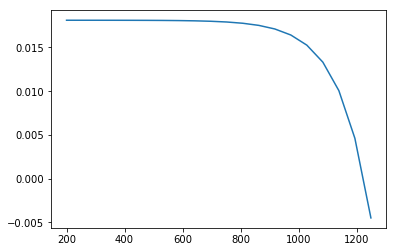

In [19]:
V_values = np. linspace(200., eps, 30)
dat = np.array(add_data)[0][0]
plt.plot(V_values[0:len(dat)], dat)
plt.show()

In [ ]:
def photocurrent_vs_phonon_coupling(eps1, eps2, T_EM=1000., Gamma_EM=0.5, T_ph=77., Gamma=30., w0=70., U=0., N=10,
                               gamma_L=1., T_L=77., mu_L=1000., width_L=1000., pos_L=1000.,
                               gamma_R=1., T_R=77., mu_R=0., width_R=1000., pos_R=1000.,
                               height_L=1., height_R=1., method='iterative-gmres'):
    ti = time.time()
    eps = abs(eps2-eps1)
    alpha_prop = np. linspace(0., 1., 15)
    print "RC would need {} states to fill electronic gap.".format(eps/w0)
    currents_nonadd = []
    
    H = build_H(eps1, eps2, U)
    d_sub = d1+d2
    d_RC = tensor(d_sub, qeye(N))
    E_RC = tensor(n, qeye(N))
    RC_occ = destroy(N).dag()*destroy(N)
    RC_occ_ = tensor(I_sys, RC_occ)
    obs_ops = [E_RC, RC_occ_]
    for i, alphap in enumerate(alpha_prop):
        alpha_ph = alphap*eps/pi
        L_RC, H_RC, A_EM, A_nrwa, Z, _, _, _ = RC_function_UD(H, n_sub, d_sub, T_ph,
                                                            Gamma, w0, alpha_ph,
                                                            N, silent=True)
        _, H_add, _, _, _, _, _, _ = RC_function_UD(H, n_sub, d_sub, T_ph,
                                                            Gamma, w0, 0.,
                                                            N, silent=True)
        L_EM_add = EM.L_non_rwa(H_add, A_nrwa, eps, Gamma_EM, T_EM, J=J_EM, silent=True)
        L_EM_full = EM.L_non_rwa(H_RC, A_nrwa, eps, Gamma_EM, T_EM, J=J_EM, silent=True)
        L_Lfull, L_Rfull = L_R_lead_dissipators(H_RC, d_RC,
                                            T_L=T_L, mu_L=mu_L, width_L=width_L,
                                            pos_L=pos_L, height_L=height_L,
                                            T_R=T_R, mu_R=mu_R, width_R=width_R,
                                            pos_R=pos_R, height_R=height_R)
        currents_add.append(current_from_L(H_RC, L_RC+L_Lfull+L_Rfull+L_EM_add, 
                                            L_Radd, obs_ops, method=method))
        currents_nonadd.append(current_from_L(H_RC, L_RC+L_Lfull+L_Rfull+L_EM_full,
                                            L_Rfull, obs_ops, method=method))
        del L_Lfull, L_Rfull, L_RC, H_RC, H_add, A_EM, A_nrwa, Z
        if (i%10)==0:
            print 100*(float(i)/len(alpha_prop)), "% complete"
    print "Took {} seconds.".format(time.time()-ti)
    return alpha_prop,  np.array(currents_nonadd).T


In [ ]:


def photocurrent_vs_phonon_coupling(eps, T_ph, Gamma, w0, T_EM=5800., N=10, 
                                    T_L=77., T_R=77., mu_L=100., mu_R=900.,
                                    Gamma_EM=1.):
    ti = time.time()
    alpha_prop = np. linspace(0, 1., 50)
    print "RC would need {} states to fill electronic gap.".format(eps/w0)
    currents_add = []
    currents_nonadd = []
    d_RC = tensor(d, qeye(N))
    E_RC = tensor(E, qeye(N))
    
    #timelist = np.linspace(0, 3/Gamma_EM, 360)
    for i, alphap in enumerate(alpha_prop):
        alpha_ph = alphap*eps/pi
        L_RC, H_RC, A_EM, A_nrwa, Z, _, _, _, = RC.RC_function_UD(d, eps, T_ph, Gamma, w0, alpha_ph, 
                                                         N, silent=True)
        L_EM_add = EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T_EM, J_EM, silent=True)
        L_EM_full = EM.L_non_rwa(H_RC, A_nrwa, eps, Gamma_EM, T_EM, J=J_EM, silent=True)
        L_L_add = additive_lead_dissipator(eps, d_RC, T_L, mu_L, Gamma_l)
        L_R_add = additive_lead_dissipator(eps, d_RC, T_R, mu_R, Gamma_l)
        L_L_full, L_R_full = fl.L_R_lead_dissipators(H_RC, d_RC, eps, T_L, mu_L, Gamma_l, T_R, mu_R, Gamma_l)
        currents_add.append(current_from_L(H_RC, L_RC+L_EM_add+L_L_add+L_R_add, L_R_add, E_RC))
        currents_nonadd.append(current_from_L(H_RC, L_RC+L_EM_full+L_L_full+L_R_full, L_R_full, E_RC))
        if (i%10)==0:
            print 100*(float(i)/len(alpha_prop)), "% complete"
    print "Took {} seconds.".format(time.time()-ti)
    return alpha_prop, currents_add, currents_nonadd